In [1]:
from functools import partial

import torch
import torch.nn as nn
import numpy as np

import wandb
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# from model import NeuralGraph
from NeuralGraph import NeuralGraph
from message import *
from update import *
from attention import *

/home/yegor/miniconda3/envs/yegor/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = 'cpu'
BS = 64
NODES = 4

ch_n = 8
ch_e = 8
ch_extra = 6

message_gen = lambda **kw: nn.Sequential(
    nn.Linear((ch_n+ch_extra)*2 + ch_e, ch_n*2 + ch_e),
    nn.ReLU(),
)

update_gen = lambda **kw: nn.Sequential(
    nn.Linear(ch_n*3 + ch_extra, ch_n),
)


ngraph = NeuralGraph(
    NODES, 1, 1,
    message_generator=message_gen,
    update_generator=update_gen,
    aggregation='mean',
    value_init='trainable',
    connections = [(i, i+1) for i in range(NODES-1)],
    ch_n=ch_n, ch_e=ch_e,
    n_models=1,
).to(DEVICE)

In [3]:
STEPS = 1_000

criterion = nn.MSELoss()

optimizer = torch.optim.RMSprop(ngraph.parameters(), lr=1e-3, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, STEPS)
log = []

In [4]:
bar = tqdm(range(STEPS))
for i in enumerate(bar):
    x = torch.randint(0, 2, size=(BS, 1), device=DEVICE).float()
    y = x

    ngraph.init_vals(batch_size=BS)
    y_hat = ngraph.forward(x, time=10, dt=1, nodes=True, edges=True)

    task_loss = criterion(y, y_hat)
    overflow = ngraph.overflow()
    loss = task_loss + overflow

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(ngraph.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    mgrad = torch.norm(next(ngraph.messages.parameters()).grad.detach())
    ugrad = torch.norm(next(ngraph.updates.parameters()).grad.detach())
    node_grad = torch.norm(ngraph.init_nodes.grad)
    edge_grad = torch.norm(ngraph.init_edges.grad)
    
    entry = {
        'loss': task_loss.item(),
        'overflow': overflow.item(),
        'mgrad': mgrad.item(),
        'ugrad': ugrad.item(),
        'node_grad': node_grad.item(),
        'edge_grad': edge_grad.item(),
    }
    
    bar.set_postfix(entry)
    log.append(entry)
print(f'final loss: {log[-1]["loss"]:.4f}')

100%|█████████████| 1000/1000 [00:17<00:00, 58.76it/s, loss=0, overflow=0, mgrad=0, ugrad=0, node_grad=0, edge_grad=0]

final loss: 0.0000


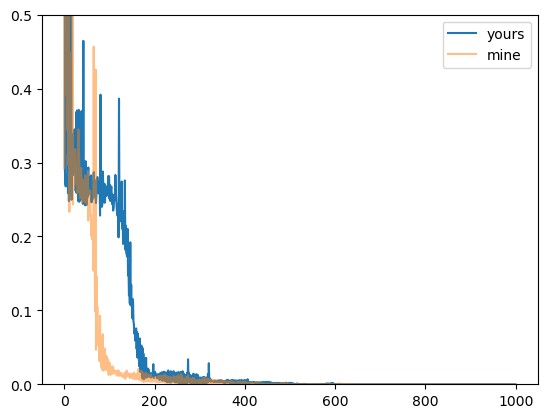

In [6]:
# my_log = torch.load("my_log.pt")
plt.plot([e["loss"] for e in log], label='yours')
# plt.plot([e["loss"] for e in my_log], label='mine', alpha=0.5)
plt.ylim(0, 0.5)
plt.legend()
plt.show()

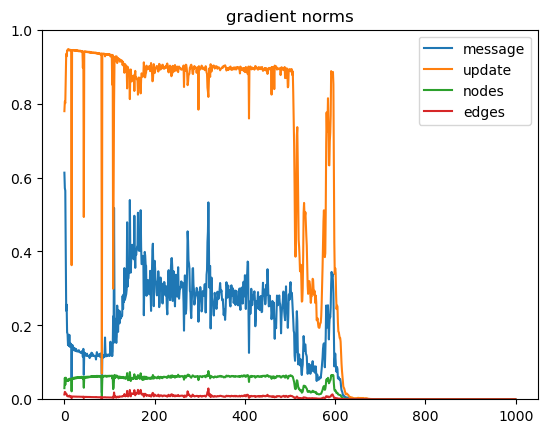

In [8]:
plt.plot([e["mgrad"] for e in log], label='message')
plt.plot([e["ugrad"] for e in log], label='update')
plt.plot([e["node_grad"] for e in log], label='nodes')
plt.plot([e["edge_grad"] for e in log], label='edges')
plt.title('gradient norms')
plt.ylim(0, 1.0)
plt.legend()
plt.show()